In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sb

### Load Data

In [2]:
# 325 patients; expression data and clinical data
gene_data = pd.read_csv('data/study_1/expression_data.csv')
clinical_data = pd.read_csv('data/study_1/clinical_data.csv')

### Sample Data Samples - Expression

In [3]:
gene_data.head()

,Gene_Name,CGGA_1001,CGGA_1006,CGGA_1007,CGGA_1011,CGGA_1015,CGGA_1019,CGGA_1022,CGGA_1023,CGGA_1024,...,CGGA_1246,CGGA_1275,CGGA_1450,CGGA_1460,CGGA_1475,CGGA_243,CGGA_247,CGGA_738,CGGA_759,CGGA_D30
0,A1BG,12.64,7.03,30.09,6.64,1.83,39.03,12.96,9.28,2.35,...,4.46,28.42,19.32,2.24,18.89,4.03,5.29,4.64,7.07,31.41
1,A1BG-AS1,2.12,1.13,6.64,4.32,1.39,4.46,3.25,1.90,1.22,...,1.57,8.36,2.21,1.60,5.31,2.47,3.69,0.85,1.99,2.65
2,A2M,452.92,106.54,206.70,707.17,824.32,155.14,538.33,26.39,219.35,...,87.20,243.89,73.80,111.50,340.53,108.06,97.24,160.70,263.66,192.54
3,A2M-AS1,3.30,0.13,0.63,1.61,1.34,3.08,0.72,1.96,1.48,...,0.42,1.02,0.22,0.15,0.91,0.33,0.03,0.38,0.48,2.51
4,A2ML1,0.04,0.33,4.96,1.59,0.00,0.10,0.39,2.34,0.68,...,2.58,0.55,0.15,1.75,0.05,1.55,0.71,3.33,0.60,3.86


### Sample Data Samples - Clinical

In [4]:
clinical_data.head()

,CGGA_ID,PRS_type,Histology,Grade,Gender,Age,OS,Censor,Radio_status,Chemo_status,IDH_mutation_status,1p19q_codeletion_status
0,CGGA_1001,Primary,GBM,WHO IV,Male,11,3428.0,0.0,0.0,1.0,Wildtype,Non-codel
1,CGGA_1006,Primary,AA,WHO III,Male,42,254.0,1.0,1.0,1.0,Wildtype,Non-codel
2,CGGA_1007,Primary,GBM,WHO IV,Female,57,345.0,1.0,1.0,1.0,Wildtype,Non-codel
3,CGGA_1011,Primary,GBM,WHO IV,Female,46,109.0,1.0,1.0,0.0,Wildtype,Non-codel
4,CGGA_1015,Primary,GBM,WHO IV,Male,62,164.0,1.0,1.0,0.0,Wildtype,Non-codel


### Data Statistics

In [5]:
print(f'Number of Data Samples: {len(gene_data.columns)-1}')
print(f'Number of Genes: {len(gene_data.index)}')

Number of Data Samples: 325
Number of Genes: 24326


The original data set consists of 325 data samples with 24000+ genes.

## Data Preprocessing

- Impute the class labels (tumor grade) and histology daa as some of the vales are 'NaN'
- Impute using the most frequent value in the column

In [6]:
class_label_col = ['Grade']
histology_col = ['Histology']
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
class_labels = imputer.fit_transform(clinical_data[class_label_col])
histology = imputer.fit_transform(clinical_data[histology_col])
class_labels_categories = list(np.unique(class_labels))

### Visualize Class Distribution

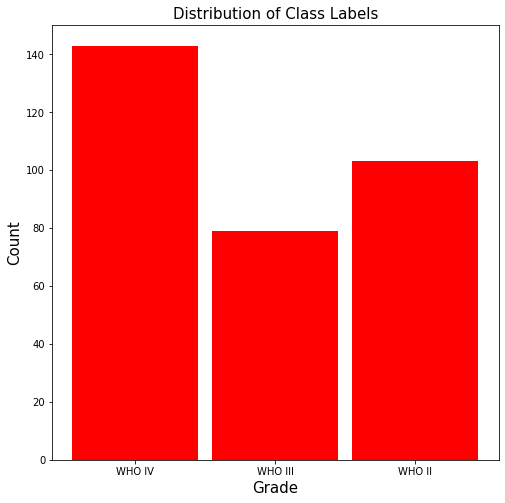

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.hist(class_labels, bins=range(4),  color=['red'], rwidth=0.90, align='left')
ax.set_xlabel('Grade', size=15)
ax.set_ylabel('Count', size=15)
ax.set_title('Distribution of Class Labels', size=15)
plt.show()

In [8]:
unique, counts = np.unique(class_labels, return_counts=True)
print('Counts for labels: ')
for i in range(len(unique)):
    print(f'Class: {unique[i]}, Count: {counts[i]}')

Counts for labels: 
Class: WHO II, Count: 103
Class: WHO III, Count: 79
Class: WHO IV, Count: 143


### Visualize Histology Distribution

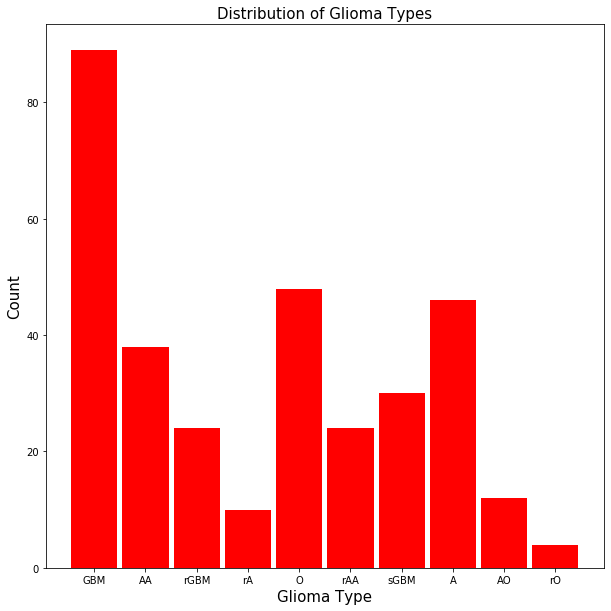

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(histology, bins=range(11),  color=['red'], rwidth=0.90, align='left')
ax.set_xlabel('Glioma Type', size=15)
ax.set_ylabel('Count', size=15)
ax.set_title('Distribution of Glioma Types', size=15)
plt.show()

In [10]:
unique, counts = np.unique(histology, return_counts=True)
print('Counts for glioma types: ')
for i in range(len(unique)):
    print(f'Type: {unique[i]}, Count: {counts[i]}')

Counts for glioma types: 
Type: A, Count: 46
Type: AA, Count: 38
Type: AO, Count: 12
Type: GBM, Count: 89
Type: O, Count: 48
Type: rA, Count: 10
Type: rAA, Count: 24
Type: rGBM, Count: 24
Type: rO, Count: 4
Type: sGBM, Count: 30


## Feature Selection
- Select a subset of the over 24 000 features to investigate and analyze 
- NOTE: the paper that used the Chinese Glioma data did a feature selection thing called t-SNE. I tried to do it but couldn't figure it out
<br/><br/>
- This is the 'standard pipeline' according to Townes, F.W., Hicks, S.C., Aryee, M.J. et al. Feature selection and dimension reduction for single-cell RNA-Seq based on a multinomial model. Genome Biol 20, 295 (2019). https://doi.org/10.1186/s13059-019-1861-6:
    - "First, raw counts are normalized by scaling of sample-specific size factors, followed by log transformation, which attempts to reduce skewness. 
    - Next, feature selection involves identifying the top 500–2000 genes by computing either their coefficient of variation (highly variable genes [16, 17]) or average expression level (highly expressed genes) across all cells [15]. 
    - Principal component analysis (PCA) [19] is the most popular dimension reduction method (see for example tutorials for Seurat [17] and Cell Ranger [5]). 
        - PCA compresses each cell’s 2000-dimensional expression profile into, say, a 10-dimensional vector of principal component coordinates or latent factors. 
        - Prior to PCA, data are usually centered and scaled so that each gene has mean 0 and standard deviation 1 (z-score transformation). 
    - Finally, a clustering algorithm can be applied to group cells with similar representations in the low-dimensional PCA space."
<br/><br/>
- I did the step that selects by variance and the PCA (with scaling)
- Still need to do:
    - Normalization of raw counts
    - Log transformation
    - Can also try selecting by expression level instead of variance

In [11]:
# TO DO

In [54]:
# Variance filter (eliminate genes that don't vary bw samples)

from sklearn.feature_selection import VarianceThreshold

# Split data into train (80%) and test (20%) sets
train_genes, test_genes, train_lbl, test_lbl = train_test_split( gene_data.loc[:, 'CGGA_1001':'CGGA_D30'].T, 
                                                                class_labels, test_size=1/5.0, random_state=0)

# Make an instance of VarianceThreshold model
selector = VarianceThreshold(12)

# Eliminate genes with <50% variance
selector.fit(train_genes)
train_genes_filtered = selector.transform(train_genes)
test_genes_filtered = selector.transform(test_genes)

print(f"Filter reduced number of genes by {len(gene_data.index) - len(train_genes_filtered[0])} from {len(gene_data.index)} to {len(train_genes_filtered[0])}")


Filter reduced number of genes by 13187 from 24326 to 11139


In [57]:
# PCA after filter

# Standardize based on filtered training set
scaler = StandardScaler()
scaler.fit(train_genes_filtered)
# Apply transform to both the training set and the test set.
train_genes_filtered = scaler.transform(train_genes_filtered)
test_genes_filtered = scaler.transform(test_genes_filtered)


# Make an instance of the model that explains 95% of the variance
pca = PCA(.95)

# Fit the model
pca.fit(train_genes_filtered)
pca.transform(train_genes_filtered)
pca.transform(test_genes_filtered)

print(f'PCA with {pca.n_components_} components explains {sum(pca.explained_variance_ratio_)} of the variance after filtering.')

PCA with 154 components explains 0.9503251337083256 of the variance after filtering.


## Unsupervised Machine Learning Method Analysis

In [13]:
# To Do